In [86]:
%run setup.py
%load_ext autoreload 
%autoreload 2

from keplergl import KeplerGl
import geopandas as gpd

import cba as cba
from cba_result import CbaResult

from IPython.core.display import display, HTML
import matplotlib.pyplot as plt
from ipywidgets import *
from IPython.display import display
from IPython.html import widgets
plt.style.use('seaborn')

display(HTML("<style>.container { width:95% !important; }</style>"))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [196]:
gdf = gpd.read_file(abspath(join('..', 'data', 'sections_generated.gpkg')))

cba_model = cba.CostBenefitAnalysisModel()


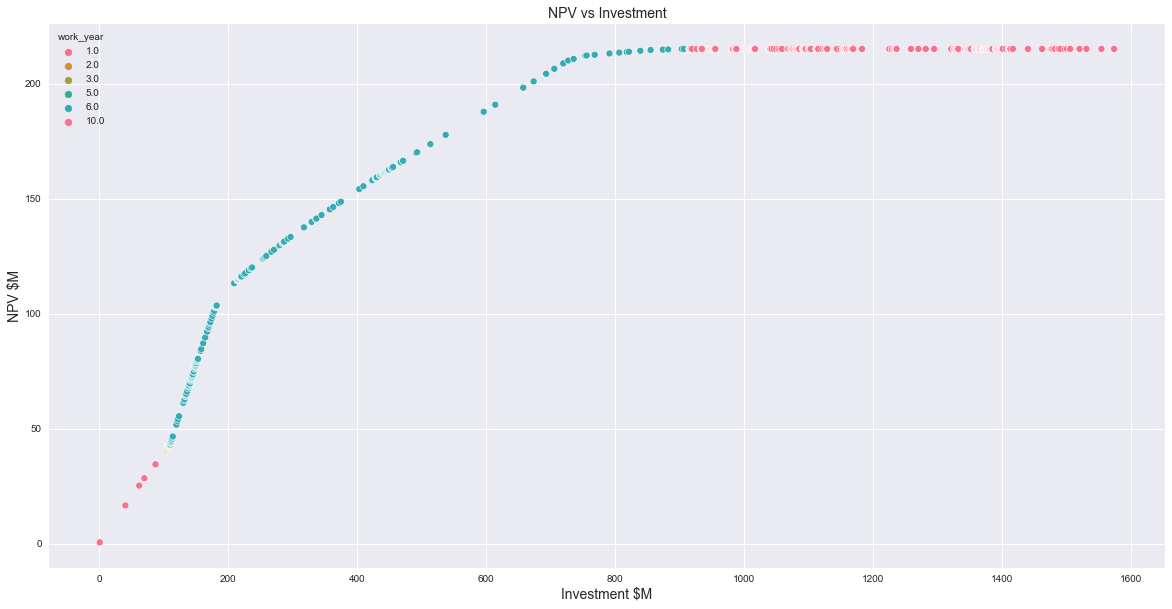

In [210]:
def generate_outputs(growth, limit):
    foo = gdf.assign(section_traffic_growth = growth).head(limit)
    input = foo.apply(lambda row: Section.from_row(row), axis=1)
    output = [cba_model.compute_cba_for_section(i) for i in input]

    output = pd.DataFrame([e.to_dict() for e in output])
    cols_to_drop = [e for e in list(output.columns) if re.match('.*_[0-9].*', e)]
    output = output.drop(columns=cols_to_drop)
    
    map_data = output.merge(gdf, right_on='way_id_district', left_on='orma_way_id')
    
    map_data.sort_values(by=['work_year', 'npv_cost'], ascending=[True, False], inplace=True)
    map_data['cum_investment'] = np.cumsum(map_data['work_cost'])
    map_data['cum_npv'] = np.cumsum(map_data.npv)

    return map_data


def plot_cum_npv(map_data):
    plt.figure(figsize=(20,10))
    sns.scatterplot(data=map_data, x='cum_investment', y='cum_npv', hue='work_year', palette='husl')
    plt.xlabel("Investment $M", fontsize=14)
    plt.ylabel("NPV $M", fontsize=14)
    plt.title(f'NPV vs Investment', fontsize=14)

plot_cum_npv(generate_outputs(3, len(gdf)))

In [215]:
def handle_growth(growth):
    df = generate_outputs(growth, 200)
    plot_cum_npv(df)
    plt.figure()
    invest_by_year = df.groupby('work_year')['work_cost'].sum().reset_index()
    sns.barplot(data=invest_by_year, x='work_year', y='work_cost',  palette='Set2')
    
interact(handle_growth, growth=(1,5,1))

interactive(children=(IntSlider(value=3, description='growth', max=5, min=1), Output()), _dom_classes=('widget…

<function __main__.handle_growth(growth)>

In [18]:
config_file = join('.', 'kepler_config.json')
with open(config_file, 'r') as file:
    config = eval(''.join(file.readlines()))

In [197]:
map_1 = KeplerGl(height=1000, config=config)
map_1.add_data(data=map_data, name="homogeneous_links")


User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


In [198]:
map_1

KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [{'dataId': ['homogeneous_links'], 'id': …

In [126]:
import matplotlib.pyplot as plt
from ipywidgets import *
from IPython.display import display
from IPython.html import widgets
plt.style.use('seaborn')

def handle_year(y):
    plt.plot(map_data.groupby('work_year')['work_cost'].sum())
    plt.xlabel("Year")
    plt.ylabel("Investment $M")
    plt.title(f'Recommended Investment by Year')
    
interact(handle_year, y=(1,10,1))

interactive(children=(IntSlider(value=5, description='y', max=10, min=1), Output()), _dom_classes=('widget-int…

<function __main__.handle_year(y)>

In [9]:
with open(config_file, 'w') as file:
    file.write(str(map_1.config))